# ELEC 425 - Assignment 1
## Handwritten Digit Data

# Summary of Results

Below are the summary results from classifiying the test data using the Conditional Gaussian Classifier, and the Naive Bayes Classifier. Further details, including the implementation code, are below.

<img src='https://i.imgur.com/UoP1jrg.png'>

<img src='https://i.imgur.com/WgicZsE.png'>

When I ran the classifiers first, I achieved these results:

<img src='https://i.imgur.com/frUsSgd.png'>

However, I ran the Naive Bayes classifier again after I had normalized the training and test data. It improved the results (not much of a change was observed for the Gaussian classifier).

<img src='https://i.imgur.com/cTGKkiy.png'>

# Data Exploration

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data
X = sio.loadmat('a1digits.mat')['digits_train'] # Training data
Y = sio.loadmat('a1digits.mat')['digits_test'] # Testing data

Show a random sequence of numbers to get an idea what the data-set looks like.

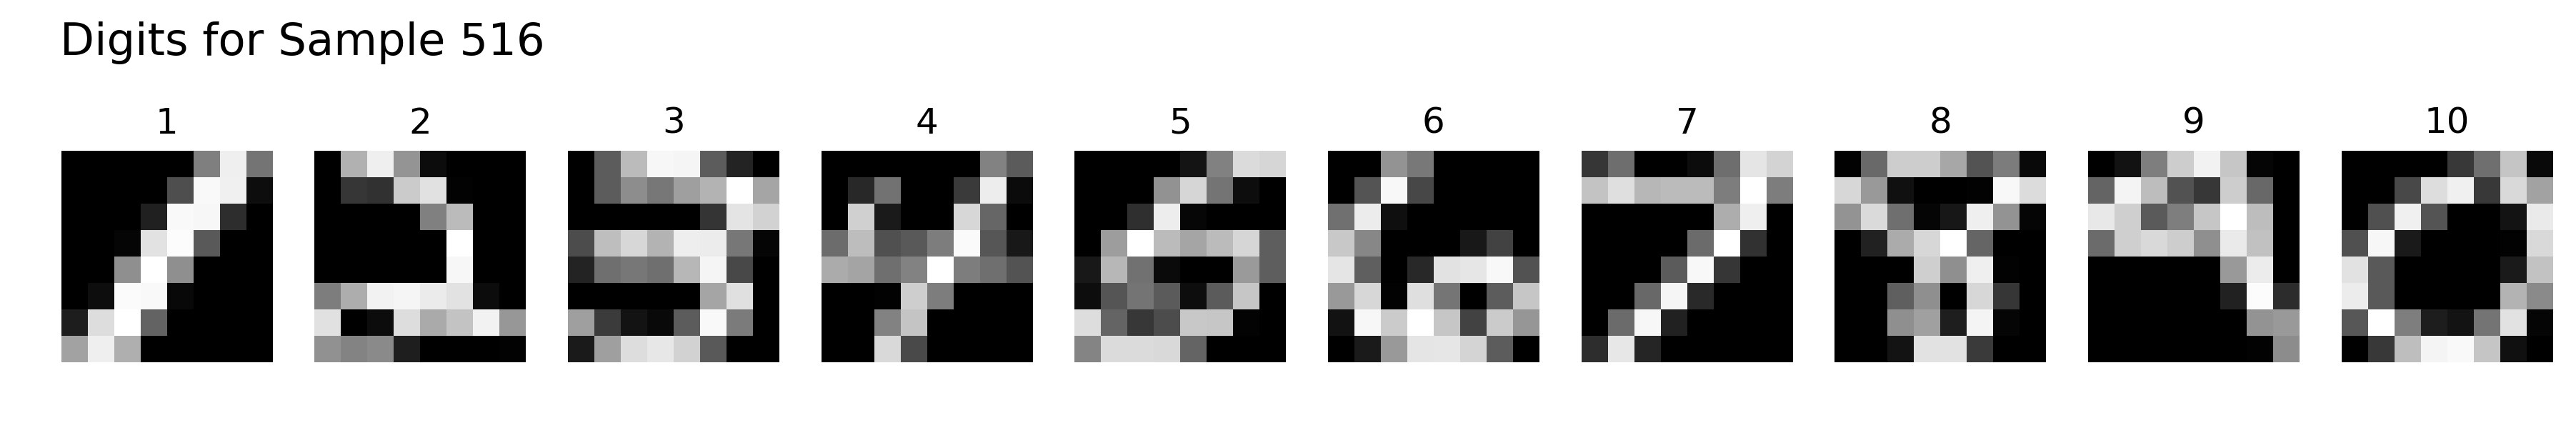

In [3]:
# Get information on the training and test set sizes
    # m - size of each image vector (64 features)
    # n - number of samples
    # k - number of digits per sample (10 digits)

m, n, k = X.shape
m2, n2, k2 = Y.shape

# Plot a random sample
num = random.randint(0,n-1)
fig, axes = plt.subplots(1, k,figsize=(15,2.3),dpi=300)
fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

for i in range(0, k):
    axes[i].imshow(np.reshape(X[:,num,i],[8,8]), cmap='Greys_r')
    axes[i].axis('off')
    axes[i].set_title(str(i+1))

# Conditional Gaussian Classifier

### Training the Conditional Gaussian Classifier

If we want, we can normalize the training and test data-sets (min-max normalization). However, I will not do this for the Gaussian classifier since it gives me poorer test performance.

In [4]:
# If desired, normalize each digit

def normalizer(X):
    """Normalize the features for each digit vector between 0 and 1"""
    m, n, k = X.shape # Understand the dimensions of the sample
    for i in range(0, k):
        for j in range(0,n):
            max_m = np.max(X[:,j,i])
            min_m = np.min(X[:,j,i])
            X[:,j,i] = np.divide((np.subtract(X[:,j,i],min_m)),(max_m-min_m))
    return X

# X = normalizer(X)
# Y = normalizer(Y)

We begin by calculating the variance, $ \sigma^{2}$, and the mean for each each digit, $\mu_{k}$.

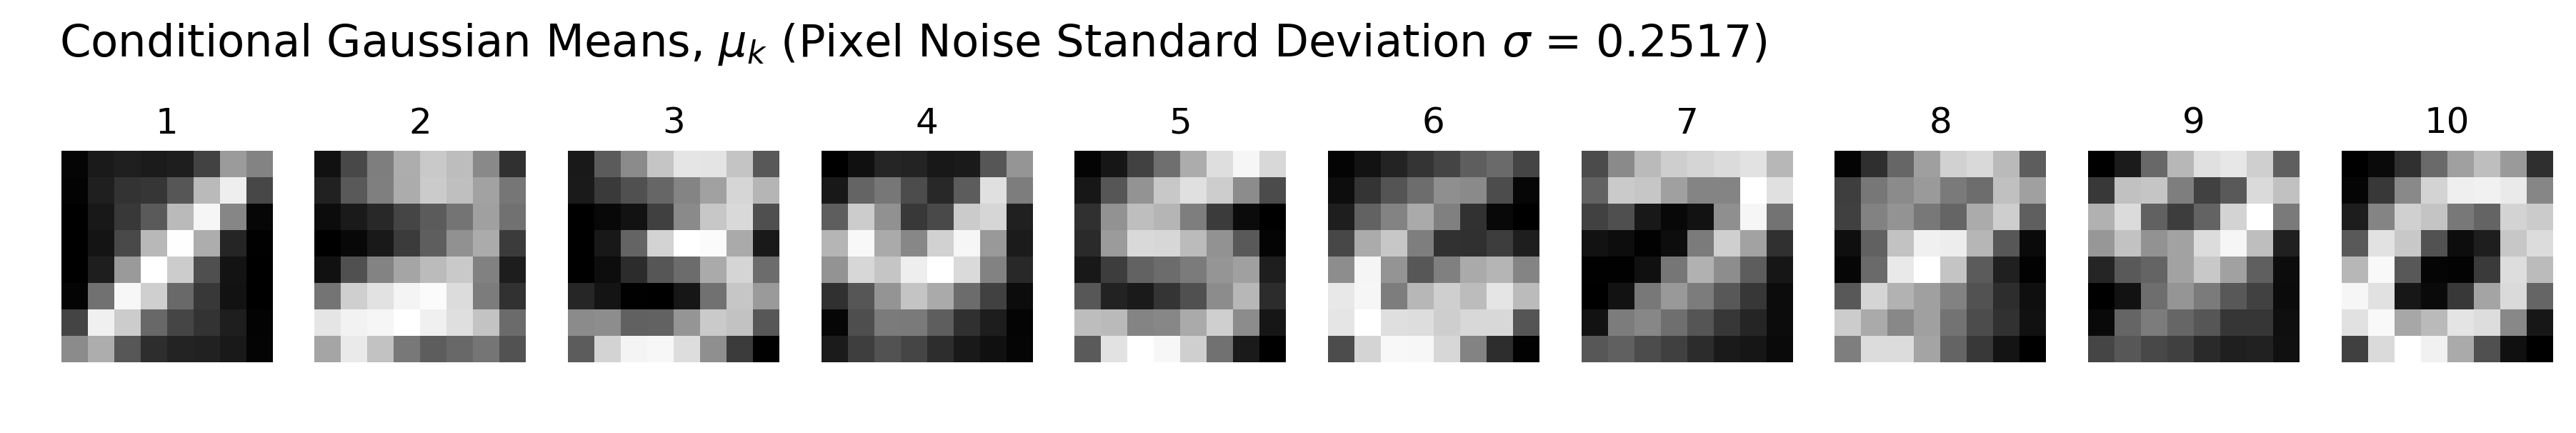

In [5]:
# Calculate the means
mu = np.mean(X,axis=1)

sigma2 =[]  # initialize the variance to zero

# Iterate through all the digits and samples to find the variance
for i in range(0,k):
    for j in range(0,n):
        s = np.sum(np.sum(np.square(X[:,j,i] - mu[:,i])))
        sigma2.append(s.tolist())

sigma2 = sum(sigma2)/(64*7000) # Variance
sigma = math.sqrt(sigma2) # Pixel noise standard deviation



# Plot the means
fig, axes = plt.subplots(1, k,figsize=(15,2.3),dpi=300)
fig.suptitle('Conditional Gaussian Means, ' r'$\mu_{k}$' 
             ' (Pixel Noise Standard Deviation ' r'$\sigma$' ' = %0.4f)' %sigma, size=15, x=0.39)

for i in range(0, k):
    axes[i].imshow(np.reshape(mu[:,i],[8,8]), cmap='Greys_r')
    axes[i].axis('off')
    axes[i].set_title(str(i+1))

In order to find the posterior, we only need to calculate the likelihood. The prior and marginal likelihood are constants, and thus can be ignored. And because we are only interested in classifying the digits, we can make the formula for calculating the likelihood very simple.

The predicted digit is: 6
The actual digit is: 10


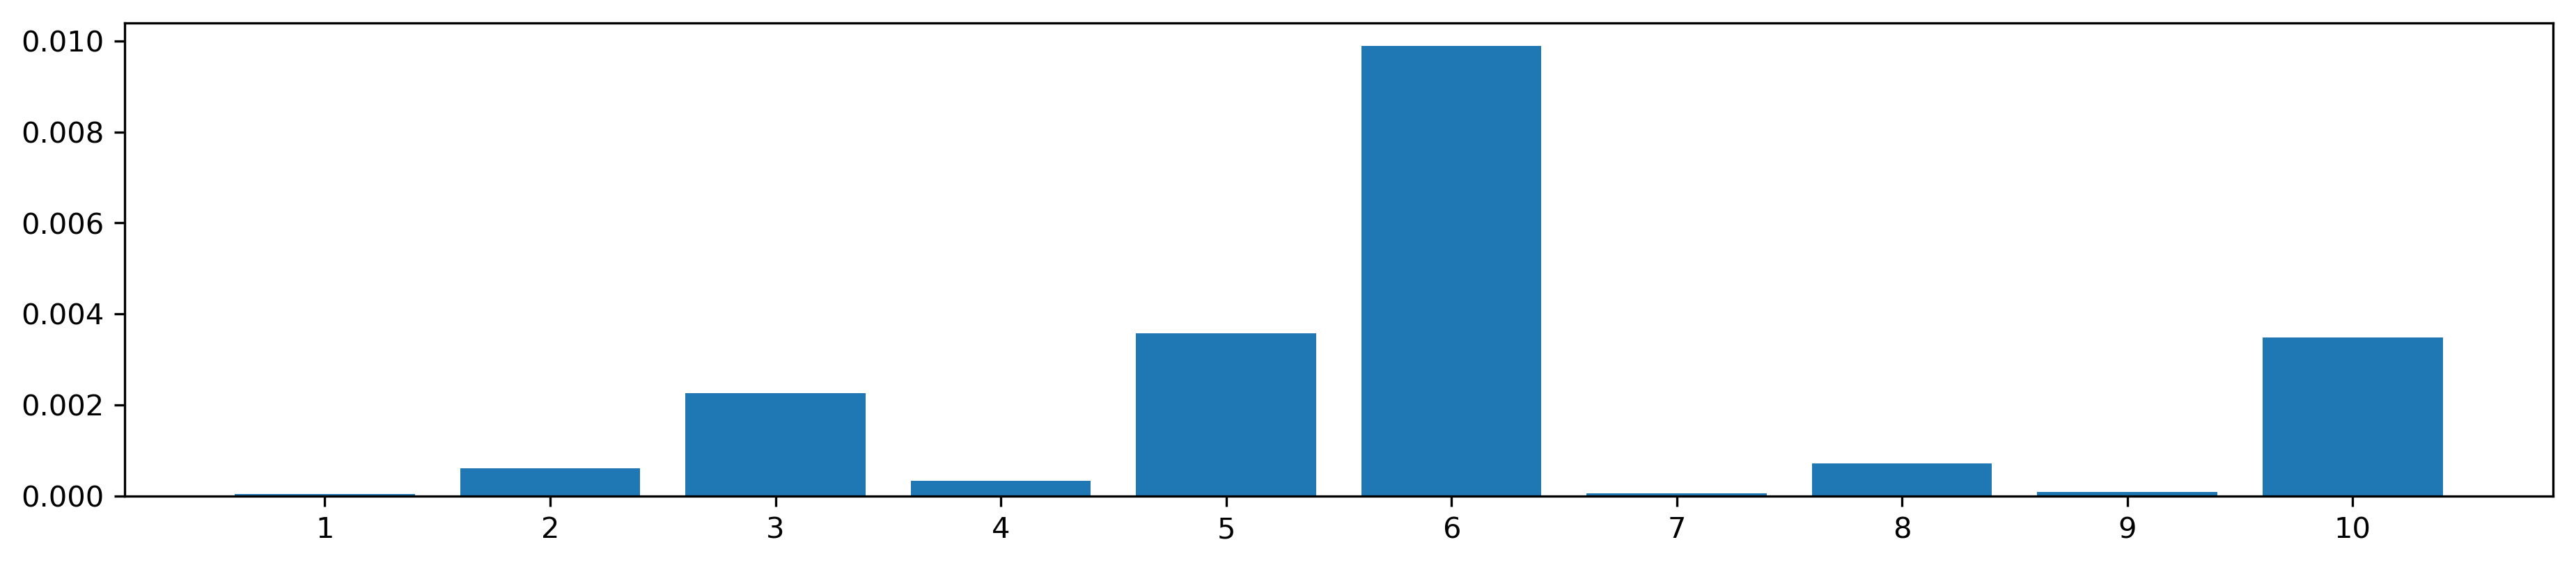

In [6]:
# Simple function to estimate the posterior probabilities
f = lambda x, mu : (math.exp(-np.sum(np.square(x-mu))))

# Test to see how this classifies a digit
l = []
max_index = 0
digit_index = 9 # Select digit 10, a zero
for i in range(0,10):
    y = f(Y[:,300,digit_index],mu[:,i])
    l.append(y)

# Plot the results
max_index = 1 + l.index(max(l))
print('The predicted digit is:',max_index)
print('The actual digit is:', digit_index+1)
fig, axes = plt.subplots(1, 1,figsize=(15,3),dpi=300)
    
plt.xticks(np.arange(1, 11, step=1))
axes.bar(range(1,11),l)
plt.show()

Interesting! The above graph shows that our Gaussian classifier classified a "zero" digit as a 6, instead of a 10. Oops! However, if you run it again for other digits you'll see that many of them are classified correctly. Regardless, it looks like our classifier is working.

### Testing the Conditional Gaussian Classifier

We will now use our test data-set to test the performance of our Conditional Gaussian Classifier.

In [7]:
# WITHOUT THE CLASSIFIER COLUMN
class_count = [] 
m2, n2, k2 = Y.shape # Load the test data

# Iterate through all the samples in our test data-set to calculate the error rate
for h in range(0,k2):
    c = [0]*10
    for x in range(0,n2):
        l = []
   
        for i in range(0,k2):
            y = f(Y[:,x-1,h],mu[:,i])
            l.append(y)
            
        max_index = l.index(max(l))
        c[max_index] = c[max_index] + 1
    
    error_count = n2 - c[h] # Calculate the number of errors for this class
    error_per = (n2-c[h])/n2 # Calculate error percentage
    c.extend([error_count, error_per]) 
    class_count.append(c)

# Create a confusion matrix showing the number of misclassified digits per class
c = [1,2,3,4,5,6,7,8,9,10,'Error Count','Error %']
r = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'])
pred = pd.DataFrame(class_count,columns=c,index=r)
pred.index.name = "Class"
pred['Error %'] = pd.Series(["{0:.1f}%".format(val * 100) for val in pred['Error %']], index = pred.index)


# Create a seperate table to just show the error count and total error rate
g_ec = np.array(class_count)
g_ec = g_ec[:,10]
g_ec = np.append(g_ec,(np.mean(g_ec)/400))
label = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','Total Error Rate'])
g_ec = pd.DataFrame(g_ec,index=label,columns=['Gaussian']).T
g_ec['Total Error Rate'] = pd.Series(["{0:.1f}%".format(val * 100) for val in g_ec['Total Error Rate']], index = g_ec.index)
g_ec[label[:-1]] = g_ec[label[:-1]].applymap(np.int64)
pred

,1,2,3,4,5,6,7,8,9,10,Error Count,Error %
Class,,,,,,,,,,,,
C1,331,9,3,10,11,3,6,27,0,0,69,17.2%
C2,5,319,7,3,8,31,4,17,1,5,81,20.2%
C3,1,10,337,0,29,4,7,4,3,5,63,15.8%
C4,29,0,0,339,2,7,0,3,19,1,61,15.2%
C5,3,1,45,4,332,1,4,6,1,3,68,17.0%
C6,19,7,3,9,1,356,0,2,0,3,44,11.0%
C7,40,1,0,4,0,0,337,3,14,1,63,15.8%
C8,29,0,23,6,17,1,2,291,28,3,109,27.3%
C9,38,2,1,19,0,0,39,11,290,0,110,27.5%


In [8]:
# Create a table showing just the total number of errors
error_table = np.array(class_count)[:,10:12]
error_table = np.append(error_table,[error_table.mean(axis=0)],0)
c = ['Error Count','Error %']
r = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','Avg Errors'])
ge = pd.DataFrame(error_table,columns=c,index=r)
ge['Error %'] = pd.Series(["{0:.1f}%".format(val * 100) for val in ge['Error %']], index = ge.index)
ge

,Error Count,Error %
C1,69.0,17.2%
C2,81.0,20.2%
C3,63.0,15.8%
C4,61.0,15.2%
C5,68.0,17.0%
C6,44.0,11.0%
C7,63.0,15.8%
C8,109.0,27.3%
C9,110.0,27.5%
C10,53.0,13.2%


## Naive Bayes Classifier

## Preprocessing

For the Naive Bayes Classifier, we first have to normalize the pixel vectors, and then represent each pixel as a 1 or a 0.

In [9]:
# Reload the data
X = sio.loadmat('a1digits.mat')['digits_train'] # Training data
Y = sio.loadmat('a1digits.mat')['digits_test'] # Testing data

In [10]:
# Normalize each digit
def normalizer(X):
    """Normalize the features for each digit vector between 0 and 1"""
    m, n, k = X.shape # Understand the dimensions of the sample
    for i in range(0, k):
        for j in range(0,n):
            max_m = np.max(X[:,j,i])
            min_m = np.min(X[:,j,i])
            X[:,j,i] = np.divide((np.subtract(X[:,j,i],min_m)),(max_m-min_m))
    return X

# X = normalizer(X)
# Y = normalizer(Y)

# Represent each "pixel" in vector in terms of 1 or 0. Binarize data
X = np.where(X > 0.5, 1, 0)
Y = np.where(Y > 0.5, 1, 0)

Let's visualize what these new binarized digits look like.

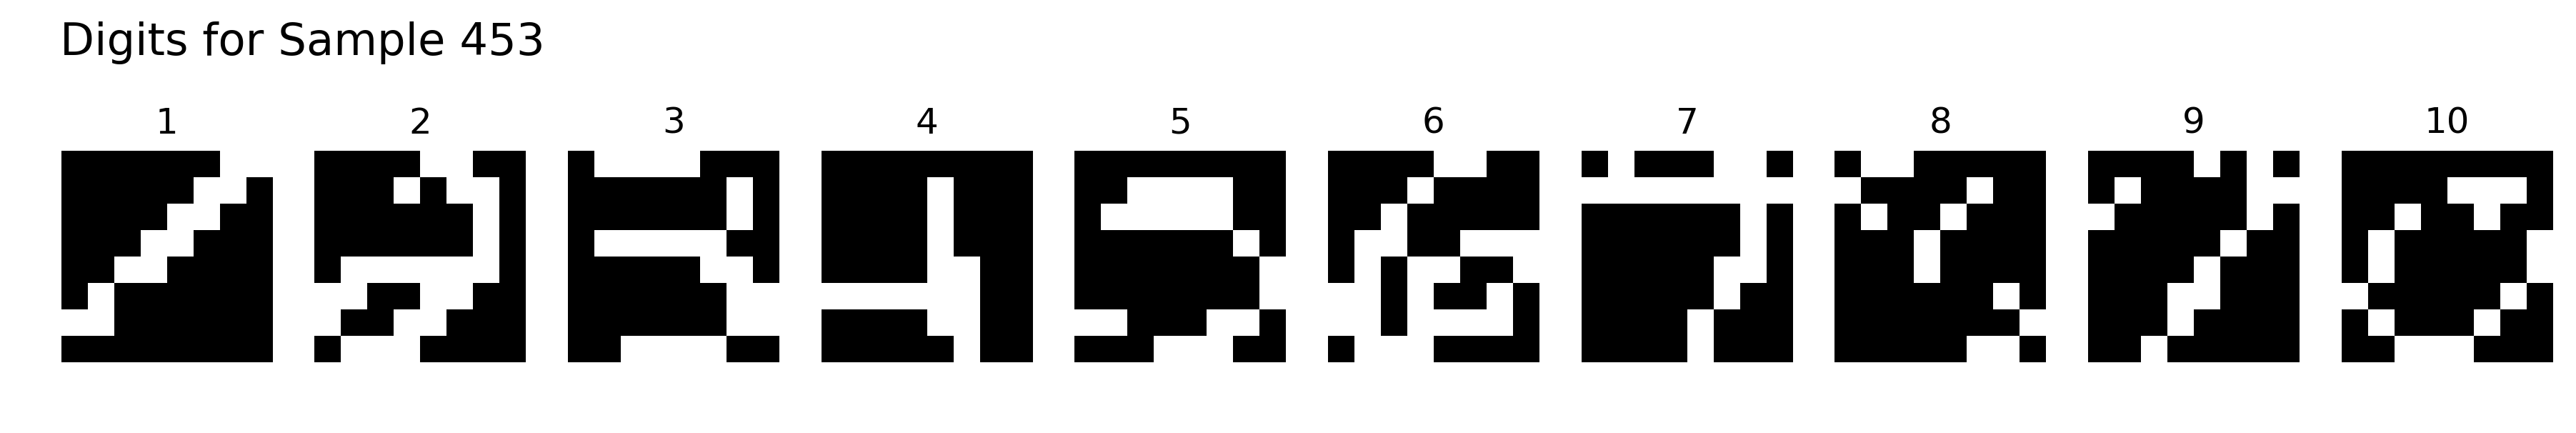

In [11]:
m, n, k = X.shape

# Plot a random sample
num = random.randint(0,n-1)
fig, axes = plt.subplots(1, k,figsize=(15,2.3),dpi=300)
fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

for i in range(0, k):
    axes[i].imshow(np.reshape(X[:,num,i],[8,8]), cmap='Greys_r')
    axes[i].axis('off')
    axes[i].set_title(str(i+1))

## Training the Naive Bayes Classifier

Calculate and visualize the Naive Bayes mean for each digit. With that, we have enough to "train" or classifier.

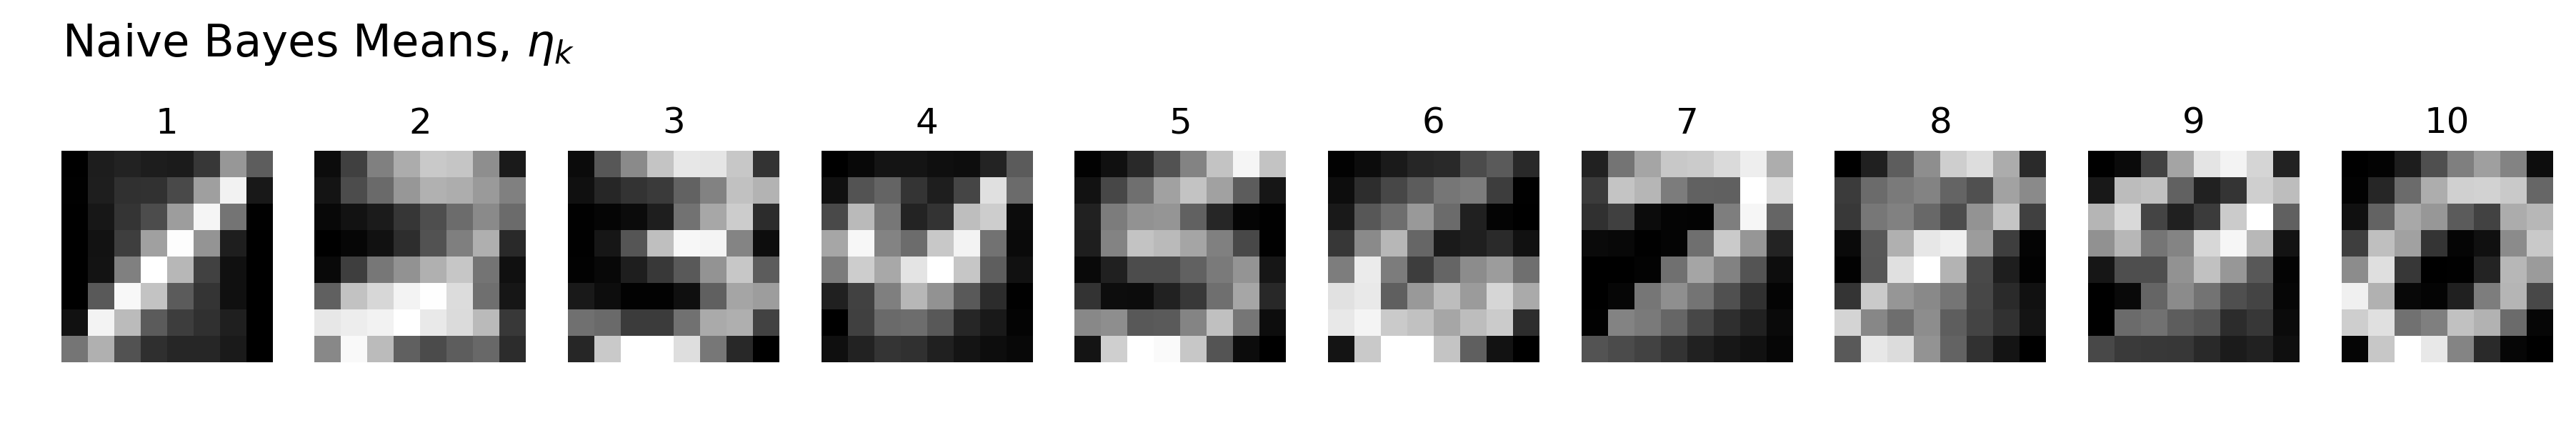

In [12]:
# Calculate the Eta's, which is the mean of all the samples, for that class
eta = np.mean(X,axis=1)

# Visualize the Eta's
fig, axes = plt.subplots(1, k,figsize=(15,2.3),dpi=300)
fig.suptitle('Naive Bayes Means, ' r'$\eta_{k}$', size=15, x=0.205)

for i in range(0, k):
    axes[i].imshow(np.reshape(eta[:,i],[8,8]), cmap='Greys_r')
    axes[i].axis('off')
    axes[i].set_title(str(i+1))
    

## Testing the Naive Bayes Classifier

Now we can begin classifying our test data. We'll plot a prediction below to see how it works.

The predicted digit is: 1
The actual digit is: 1


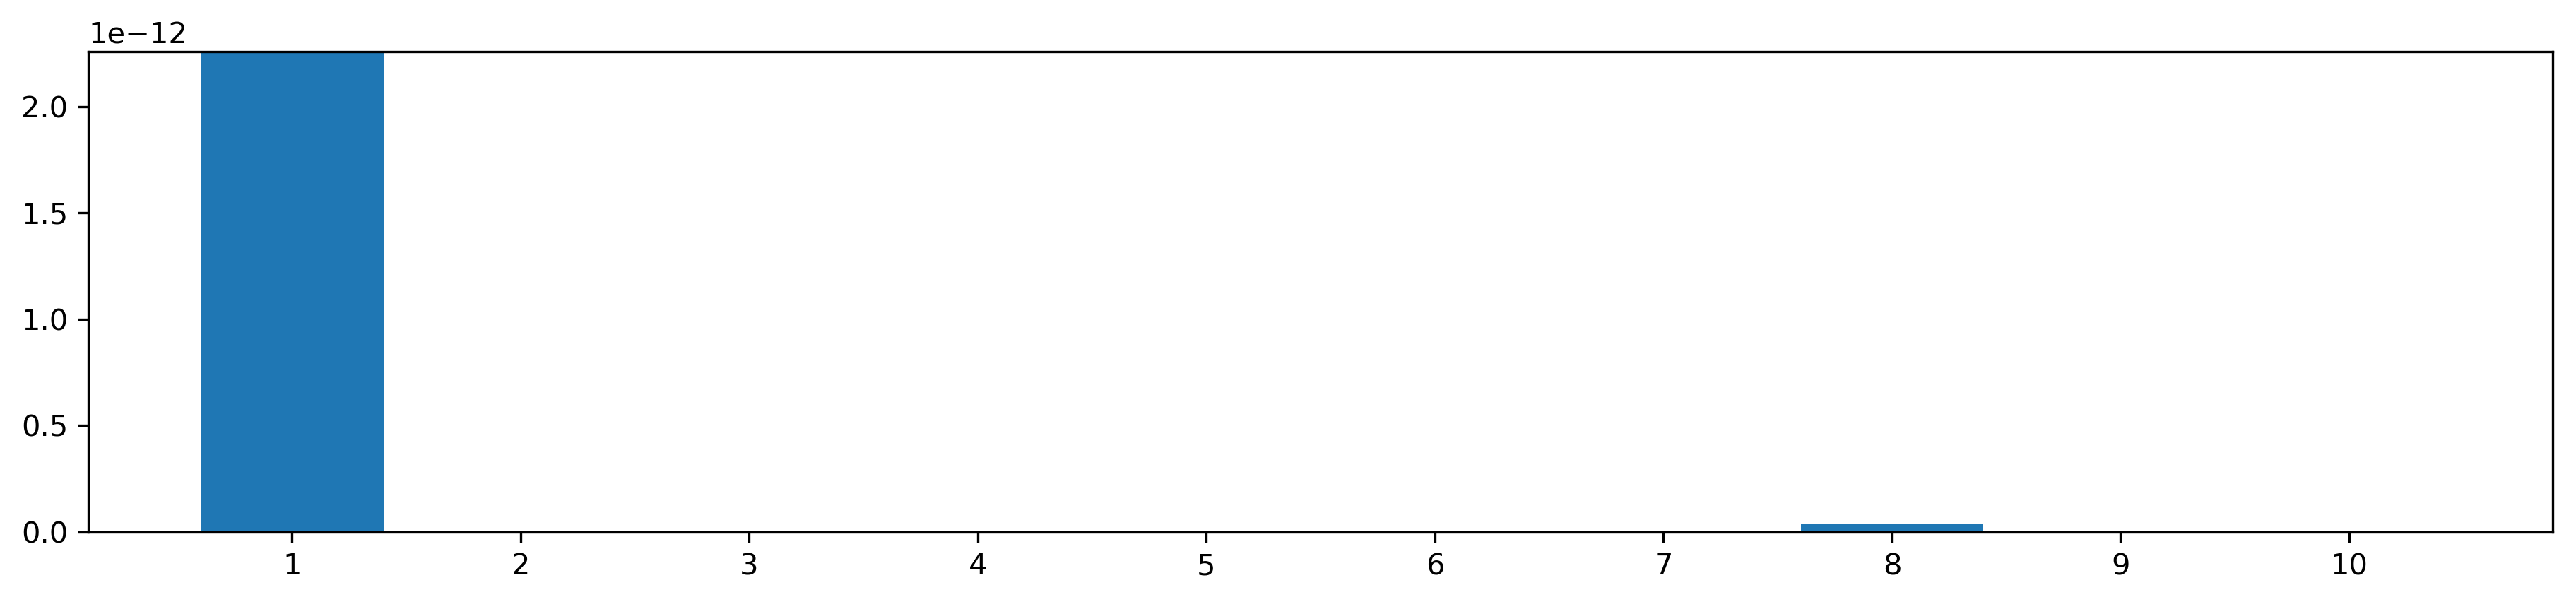

In [13]:
def naive_bayes(eta, x):
    '''Function to classify our digits'''
    y = 1
    m = len(x)
    for i in range(0,m):
        y = y*eta[i]**(x[i])*(1-eta[i])**(1-x[i]) 
    return y    

l = []
max_index = 0
digit_index = 0

for i in range(0,10):
    y = naive_bayes(eta[:,i], Y[:,151,digit_index])
    l.append(y)

max_index = 1 + l.index(max(l))
print('The predicted digit is:',max_index)
print('The actual digit is:', digit_index+1)
fig, axes = plt.subplots(1, 1,figsize=(15,3),dpi=300)
    
plt.xticks(np.arange(1, 11, step=1))
axes.bar(range(1,11),l)
plt.show()

Seems like the classifier works!

Next, we'll test our classifier on all the test data to see what the error rate is.

In [14]:
def nb_test(eta, Y):
    '''Naive Bayes classifier, for use when you have already gone through training; that is,
    you've calculated the eta already. Outputs a pandas data-frame for a confusion matrix, nb1;
    a df of error count per digit, nb2; and a simple df with total error rate, n3.'''
    
    class_count = [] # Blank list to put the predictions in
    m2, n2, k2 = Y.shape # Determine the shape of the test data
    
    # Iterate through all samples to predict which class (digit) they should belong to
    for h in range(0,k2):
        c = [0]*10
        for x in range(0,n2):
            l = []
            for i in range(0,k2):
                y = naive_bayes(eta[:,i], Y[:,x-1,h])
                l.append(y)
            max_index = l.index(max(l))
            c[max_index] = c[max_index] + 1

        error_count = n2 - c[h] # Calculate the number of errors for this class
        error_per = (n2-c[h])/n2 # Calculate error percentage
        c.extend([error_count, error_per]) 
        class_count.append(c)

    # Create a confusion matrix showin the number of misclassified digits per class
    c = [1,2,3,4,5,6,7,8,9,10,'Error Count','Error %']
    r = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'])
    nb1 = pd.DataFrame(class_count,columns=c,index=r)
    nb1.index.name = "Class"
    nb1['Error %'] = pd.Series(["{0:.1f}%".format(val * 100) for val in nb1['Error %']], index = nb1.index)

    # Create a table showing the total number of errors
    error_table = np.array(class_count)[:,10:12]
    error_table = np.append(error_table,[error_table.mean(axis=0)],0)
    c = ['Error Count','Error %']
    r = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','Avg Errors'])
    nb2 = pd.DataFrame(error_table,columns=c,index=r)
    nb2['Error %'] = pd.Series(["{0:.1f}%".format(val * 100) for val in nb2['Error %']], index = nb2.index)
    
    # Create a seperate table to just show the error count and total error rate
    nb3 = np.array(class_count)
    nb3 = nb3[:,10]
    nb3 = np.append(nb3,(np.mean(nb3)/400))
    label = np.array(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','Total Error Rate'])
    nb3 = pd.DataFrame(nb3,index=label,columns=['Naive Bayes']).T
    nb3['Total Error Rate'] = pd.Series(["{0:.1f}%".format(val * 100) for val in nb3['Total Error Rate']], index = nb3.index)
    nb3[label[:-1]] = nb3[label[:-1]].applymap(np.int64)  
    return (nb1, nb2, nb3) # Return the confusion matrix and error table

In [15]:
nb1, nb2, nb3 = nb_test(eta, Y)
nb1

,1,2,3,4,5,6,7,8,9,10,Error Count,Error %
Class,,,,,,,,,,,,
C1,313,12,1,13,9,4,12,36,0,0,87,21.8%
C2,8,296,9,9,7,20,17,24,3,7,104,26.0%
C3,0,21,309,11,25,3,16,8,3,4,91,22.8%
C4,27,0,0,315,4,6,5,5,34,4,85,21.2%
C5,5,5,44,15,289,4,11,17,5,5,111,27.8%
C6,17,5,2,13,9,340,1,3,0,10,60,15.0%
C7,57,1,6,9,0,0,311,1,13,2,89,22.2%
C8,28,5,11,19,18,4,5,279,28,3,121,30.2%
C9,34,0,5,34,4,1,45,9,267,1,133,33.2%


In [16]:
nb2

,Error Count,Error %
C1,87.0,21.8%
C2,104.0,26.0%
C3,91.0,22.8%
C4,85.0,21.2%
C5,111.0,27.8%
C6,60.0,15.0%
C7,89.0,22.2%
C8,121.0,30.2%
C9,133.0,33.2%
C10,58.0,14.5%


However, the above are the result when we haven't normalized the data. What happens when we normalize our data?

In [17]:
# Reload the data
X = sio.loadmat('a1digits.mat')['digits_train'] # Training data
Y = sio.loadmat('a1digits.mat')['digits_test'] # Testing data

X = normalizer(X)
Y = normalizer(Y)

# Represent each "pixel" in vector in terms of 1 or 0. Binarize data
X = np.where(X > 0.5, 1, 0)
Y = np.where(Y > 0.5, 1, 0)

eta = np.mean(X,axis=1)

nb1_norm, nb2_norm, nb3_norm = nb_test(eta, Y)
nb2_norm

,Error Count,Error %
C1,77.0,19.2%
C2,82.0,20.5%
C3,63.0,15.8%
C4,73.0,18.2%
C5,92.0,23.0%
C6,52.0,13.0%
C7,80.0,20.0%
C8,105.0,26.2%
C9,99.0,24.8%
C10,50.0,12.5%


Aha! After we normalize the digits, the error rate decreases to 19.3%.

# Compare Conditional Gaussian and Naive Bayes Classifiers

How does the Conditional Gaussian Classifier compare to the Naive Bayes Classifier? It looks like the Conditional Guassian Classifier has a lower error rate.

In [18]:
comparison = pd.concat([g_ec, nb3],axis=0)
comparison

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Total Error Rate
Gaussian,69,81,63,61,68,44,63,109,110,53,18.0%
Naive Bayes,87,104,91,85,111,60,89,121,133,58,23.5%


However, when we normalize the digits during preprocessing (for Naive Bayes), we get a much closer result between the two classifiers.

In [19]:
comparison2 = pd.concat([g_ec, nb3_norm],axis=0)
comparison2

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Total Error Rate
Gaussian,69,81,63,61,68,44,63,109,110,53,18.0%
Naive Bayes,77,82,63,73,92,52,80,105,99,50,19.3%
